### Loading required packages

In [1]:
import arxiv
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

import pycountry
import os

In [2]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
import gensim

In [3]:
import numpy as np
import pandas as pd
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore")
%precision 4

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix

In [5]:
### loading topic modeling libraries
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
import gensim

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

### Downloading the most recent pdf papers from arXiv for Astrophysics string search

In [19]:
papers = arxiv.query(query="astrophysics", max_results=200,sort_by="lastUpdatedDate")

In [18]:
for i in range(len(papers)):
    arxiv.download(papers[i], dirpath="./Astrodocs/", slugify=arxiv.slugify)

### Creating list of country, sub country regions, and cities

In [10]:
#world cities csv file is an open source file could be downloaded form --> https://datahub.io/core/world-cities
city=pd.read_csv('./world-cities_csv.csv')

#collect list of cities
cities=city['name'].unique()
cities=[s.lower() for s in cities]

#collect list of regions
sub_c=city['subcountry'].unique()
sub_c=[str(s).lower() for s in sub_c]

#collect list of countries
ccc=[]
for country in pycountry.countries:
        ccc.append(country.name)
ccc=[s.lower() for s in ccc]
ccc.append('usa')
ccc.append('uk')

In [11]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["physics",'astronomy','astrophysics',"using", 'measurements','measurement','measuremen',"show", "result", "large", "also", "department","university","laboratory","institute","national","previously", "shown",'universit','institut','departmen']
stop_words = stop_words.union(new_words).union(cities).union(ccc).union(sub_c)

### Text Processing

Assumption 1: 

- The country of the author will be referenced as location henceforth
- If there are more than one author, the recognized locations of all the author will be considered for processing

Assumption 2:

The body of text before the **"Introduction"** section of the paper is considered as **"Abstract"** for the paper. These will be used to extract keywords/topics for the documents. All the extracted keywords would be equally assigned to all the extracted locations

In [7]:
# Class module to read pdf documents to text
class PdfConverter:

   def __init__(self, file_path):
       self.file_path = file_path
# convert pdf file to a string which has space among words 
   def convert_pdf_to_txt(self):
       rsrcmgr = PDFResourceManager()
       retstr = StringIO()
       codec = 'utf-8'  # 'utf16','utf-8'
       laparams = LAParams()
       device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
       fp = open(self.file_path, 'rb')
       interpreter = PDFPageInterpreter(rsrcmgr, device)
       password = ""
       maxpages = 0
       caching = True
       pagenos = set()
       for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching, check_extractable=True):
           interpreter.process_page(page)
       fp.close()
       device.close()
       str = retstr.getvalue()
       retstr.close()
       return str

In [8]:
#Regex string patterns to extract text from pdf documents
pat1='(.*)abstract(.*) introduction (.*)'
pat2='(.*)contents  1 introduction(.*)'
pat3='(.*)introduction(.*)'

In [9]:
# General text processing, clean up of junk characters, lemmatization, removing stop words
def text_preprocessing(pt):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', pt)
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(WordNetLemmatizer().lemmatize(token, pos='v'))
            
    text = " ".join(result)
    return text

In [10]:
#Function to process pdf text data to extract location and text abstract of the document
def process_pdf_text(file):
    pdfConverter = PdfConverter(file_path=file)
    l=pdfConverter.convert_pdf_to_txt()
    l=l.replace("\n"," ")
    #Convert to lowercase
    l = l.lower()
    cnt=[]
    processed_text=''
    if re.search(pat1,l):
        match=re.search(pat1, l)
        location_tokens = word_tokenize(match.group(1))  
        for country in ccc:
            if country in location_tokens:
                cnt.append(country)
        abstract=match.group(2)
        processed_text=text_preprocessing(abstract)
        flag = 1
    elif re.search(pat2,l):
        match=re.search(pat2,l)
        location_tokens = word_tokenize(match.group(1))
        for country in ccc:
            if country in location_tokens:
                cnt.append(country)
        abstract=match.group(1)
        processed_text=text_preprocessing(abstract)
        flag = 1
    elif re.search(pat3,l):
        match=re.search(pat3,l)
        location_tokens = word_tokenize(match.group(1))
        for country in ccc:
            if country in location_tokens:
                cnt.append(country)
        abstract=match.group(1)
        processed_text=text_preprocessing(abstract)
        flag = 1
    else:
        flag = 0 
    
    return cnt,processed_text, flag

### Process all the downloaded docs to extract location and abstract

In [11]:
dir_path = './Astrodocs/'
processed_count=0
not_process_count=0
df_cnty_abs = pd.DataFrame()
for file in os.listdir(dir_path):
    #print (file)
    #print (dir_path+file)
    country,processed_text, flag=process_pdf_text(dir_path+file)
    if ((flag ==1) & (len(country)!=0)):
        df=pd.DataFrame()
        df['location']=country
        df['doc_name']=file
        df['abstract']=processed_text
        processed_count = processed_count+flag
        df_cnty_abs=df_cnty_abs.append(df)
    if ((flag==0)|(len(country)==0)):
        not_process_count += 1

print('Total processsed files {}'.format(processed_count))
print('Total Non processsed files {}'.format(not_process_count))

Total processsed files 171
Total Non processsed files 29


#### Of the 200 files 171 has followed either of the three regex pattern to extract text. The rest 29 either didn't follow the pattern or there was no country information

In [12]:
#Saving processed to a csv outpt for future reference. 
df_cnty_abs.to_csv('astro_phy_docs_extract.csv')

In [13]:
# Obtain number of times an author from specific location had published a paper. 
f=pd.DataFrame(df_cnty_abs['location'].value_counts()).reset_index()
f.columns=['country','count']

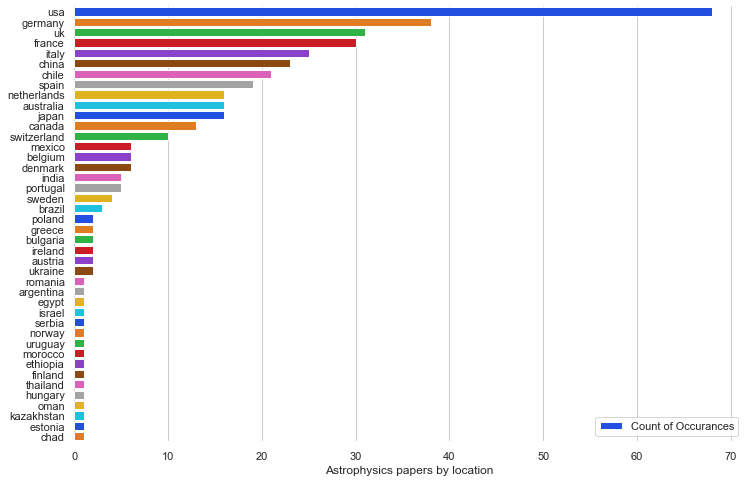

In [15]:
#Plotting country ranking
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

f=f.sort_values("count",ascending=False)

# Plot the country occurance count
sns.set_color_codes("pastel")
sns.barplot(x="count", y="country", data=f,
            label="Count of Occurances", palette='bright')

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Astrophysics papers by location")
sns.despine(left=True, bottom=True)

#### Based on the loction information extracted from the Astrophysics papers, the top 5 locations to conduct discussion groups are

1. USA
2. Germany
3. UK
4. France
5. Italy

From the analysis papers authors from 42 different locations have published papers

### Topic Modeling using bag of words and LDA

In [6]:
#df_cnty_abs=pd.read_csv('astro_phy_docs_extract.csv')

#Get corpus of document abstracts
corpus=df_cnty_abs['abstract'].unique()

In [12]:
#Ignore most common words when building vocabulary using count vectorizer
cv=CountVectorizer(max_df=0.8, max_features=1000, stop_words=stop_words)
cv_out=cv.fit_transform(corpus)

In [13]:
#Identifying the most important words for a document using term-frequency and inverse document frequency
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(cv_out)
# get feature names
feature_names=cv.get_feature_names()

In [14]:
#Functions to extract top keywords for a document (ex: 25 keywords unique to the document)

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=100):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def get_top_topics(doc):
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
    
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    
    #extract only the top n; n 
    keywords=extract_topn_from_vector(feature_names,sorted_items,25)
    
    return list(keywords.keys())

In [15]:
df_cnty_abs['topics']=df_cnty_abs['abstract'].apply(get_top_topics)

#### LDA Modeling
- Get all the keywords associated with a location based on words obtained from all the papers. 
- Importance is assigned to presence of a keyword rather than how many times it has been mentioned in different papers. 

In [18]:
#Collate all the keywords for a location from all the papers
new_df=df_cnty_abs[['location','topics']].groupby('location').sum().reset_index()

In [19]:
#Create a unique list of keywords for a location
new_df['unique_topics']=[list(set(i)) for i in new_df['topics']]

In [20]:
#create keyword corpus for a location
final_df=new_df[['location','unique_topics']]

In [21]:
#create dictionary corpus for topic model based on keywords extracted for all the locations
common_texts=list(final_df['unique_topics'])
common_dictionary = Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]

#### We will use model Coherence value to ascertain the best number of topics for a given bag of words. Higher the coherence value the better is the model

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics,id2word=dictionary,iterations=10000)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [101]:
model_list, coherence_values = compute_coherence_values(dictionary=common_dictionary, corpus=common_corpus, texts=common_texts, start=2, limit=20, step=1)

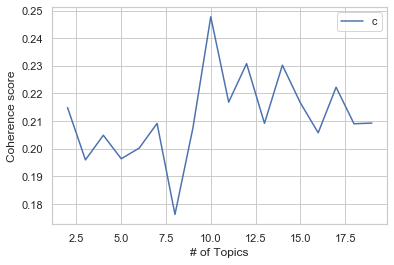

In [102]:
# Plotting number of topics and its correspoding coherence values
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("# of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [103]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2148
Num Topics = 3  has Coherence Value of 0.1959
Num Topics = 4  has Coherence Value of 0.2048
Num Topics = 5  has Coherence Value of 0.1963
Num Topics = 6  has Coherence Value of 0.2002
Num Topics = 7  has Coherence Value of 0.2091
Num Topics = 8  has Coherence Value of 0.1762
Num Topics = 9  has Coherence Value of 0.2074
Num Topics = 10  has Coherence Value of 0.2477
Num Topics = 11  has Coherence Value of 0.2168
Num Topics = 12  has Coherence Value of 0.2308
Num Topics = 13  has Coherence Value of 0.2092
Num Topics = 14  has Coherence Value of 0.2302
Num Topics = 15  has Coherence Value of 0.2166
Num Topics = 16  has Coherence Value of 0.2057
Num Topics = 17  has Coherence Value of 0.2222
Num Topics = 18  has Coherence Value of 0.209
Num Topics = 19  has Coherence Value of 0.2092


#### For the given bag of words 10 topics seems to be the best model fit based on coherence score

In [105]:
# Compute Perplexity for the optimal model
print('\nPerplexity: ', opt_mod.log_perplexity(common_corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -8.277003588394544


In [104]:
# print the top 15 keywords for each topic
from pprint import pprint
opt_mod = model_list[8]
model_topics = opt_mod.show_topics(formatted=False)
pprint(opt_mod.print_topics(num_words=15))

[(0,
  '0.005*"mass" + 0.005*"parameters" + 0.004*"ray" + 0.004*"model" + '
  '0.004*"analysis" + 0.004*"source" + 0.003*"continuum" + 0.003*"properties" '
  '+ 0.003*"active" + 0.003*"data" + 0.003*"scale" + 0.003*"sample" + '
  '0.003*"density" + 0.003*"time" + 0.003*"event"'),
 (1,
  '0.004*"emission" + 0.004*"data" + 0.004*"radio" + 0.004*"analysis" + '
  '0.004*"sample" + 0.004*"line" + 0.004*"signal" + 0.004*"spectral" + '
  '0.004*"model" + 0.004*"test" + 0.003*"object" + 0.003*"luminosity" + '
  '0.003*"galaxy" + 0.003*"study" + 0.003*"noise"'),
 (2,
  '0.004*"galactic" + 0.004*"data" + 0.004*"star" + 0.004*"mass" + '
  '0.004*"active" + 0.004*"cosmological" + 0.004*"cluster" + 0.003*"galaxies" '
  '+ 0.003*"dust" + 0.003*"scale" + 0.003*"energy" + 0.003*"supernovae" + '
  '0.003*"source" + 0.003*"order" + 0.003*"density"'),
 (3,
  '0.006*"star" + 0.005*"function" + 0.004*"term" + 0.004*"model" + '
  '0.004*"mass" + 0.004*"value" + 0.004*"power" + 0.004*"galaxies" + '
  '0.004*

### Possible Topic Explanations

**Topic 0** -- **Measure and analyse parameters like mass, density, etc.  from celestial sources**
- _Top Keywords_ --> mass, parameters, ray, model, analysis, source, continuum, properties, active, data, scale, sample, density, time , event

**Topic 1** --> **Light Emission analysis from other galaxies**
- _Top Keywords_ --> emission, data, radio, analysis, sample, line, signal, spectral, model, test, object, luminosity, galaxy, study, noise

**Topic 2** --> **Understanding supernova from other galaxies**
- _Top Keywords_ --> galactic, data, star, mass, active, cosmological, cluster, galaxies, dust, scale, energy, supernovae, source, order, density

**Topic 3** --> **Study of magnetic and spectral properties of stars**
- _Top Keywords_ --> star, function, term, model, mass, value, power, galaxies, spectral, space, distribution, state, magnetic, scale, properties

**Topic 4** --> **Study related to black holes**
- _Top Keywords_ --> disk, mass, matter, star, time, density, class, binary, universe, model, cosmological, population, hole, erent, background

**Topic 5** --> **Study of dwarfs in Milky way galaxy**
- _Top Keywords_ --> measure, body, dwarf, star, galaxy, intensity, motion, search, densities, path, techniques, peak, milky, number, dispersion

**Topic 6** --> **Analysis of Galaxy Structure and its properties using clustering**
- _Top Keywords_ --> mass, study, derive, star, density, model, astronomical, time, data, galaxy, analysis, stellar, galactic, structure, cluster

**Topic 7** --> **Modeling of solar activity using equations and functions**
- _Top Keywords_ --> function, cients, solar, spectroscopic, space, active, equations, multi, band, solutions, report, rate, visible, infer, emission

**Topic 8** --> **Study to understand sequence, structure, etc. for formation of giant galaxies** 
- _Top Keywords_ --> star, sequence, model, galaxies, techniques, structure, search, distribution, observations, study, black, erent, formation, dispersion, giant

**Topic 9** --> **Observing spectral properties of stars and galaxies**
- _Top Keywords_ --> star, study, astronomical, systems, time, data, model, cluster, spectral, mass, parameters, observe, galaxies, universe, vector


In [107]:
# Visualize the topics and the prominent words for the topics. Hovering over the topic bubble highlights the salient words
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(opt_mod, common_corpus, common_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.003082  0.003073  1       1        35.814739
2      0.009325  0.002869  2       1        34.607075
3     -0.008212 -0.021617  3       1        9.908870 
9      0.005945  0.002979  4       1        9.828371 
6      0.018175 -0.006497  5       1        3.569043 
7     -0.023152  0.000764  6       1        2.708366 
1      0.006877  0.007986  7       1        1.863012 
4      0.005526  0.000606  8       1        1.199106 
5     -0.010479  0.013176  9       1        0.437461 
8     -0.000923 -0.003339  10      1        0.063965 , topic_info=    Category       Freq             Term      Total  loglift  logprob
18   Default  24.000000  star             24.000000  30.0000  30.0000
10   Default  26.000000  mass             26.000000  29.0000  29.0000
174  Default  20.000000  model            20.000000  28.0000  28.0000
6    Default  20.000000  galaxies         20.000000  27.0000  27.0000
270  Default  18.000000  time             18.000000  26.0000  26.0000
28   Default  21.000000  active           21.000000  25.0000  25.0000
73   Default  21.000000  data             21.000000  24.0000  24.0000
218  Default  20.000000  ray              20.000000  23.0000  23.0000
19   Default  18.000000  study            18.000000  22.0000  22.0000
77   Default  20.000000  density          20.000000  21.0000  21.0000
7    Default  13.000000  galaxy           13.000000  20.0000  20.0000
120  Default  19.000000  galactic         19.000000  19.0000  19.0000
231  Default  12.000000  search           12.000000  18.0000  18.0000
5    Default  16.000000  formation        16.000000  17.0000  17.0000
529  Default  12.000000  techniques       12.000000  16.0000  16.0000
290  Default  14.000000  black            14.000000  15.0000  15.0000
302  Default  13.000000  hole             13.000000  14.0000  14.0000
95   Default  13.000000  dwarf            13.000000  13.0000  13.0000
383  Default  11.000000  sequence         11.000000  12.0000  12.0000
266  Default  15.000000  systems          15.000000  11.0000  11.0000
229  Default  19.000000  scale            19.000000  10.0000  10.0000
31   Default  18.000000  analysis         18.000000  9.0000   9.0000 
496  Default  11.000000  measure          11.000000  8.0000   8.0000 
258  Default  14.000000  stellar          14.000000  7.0000   7.0000 
265  Default  16.000000  survey           16.000000  6.0000   6.0000 
260  Default  12.000000  structure        12.000000  5.0000   5.0000 
179  Default  15.000000  noise            15.000000  4.0000   4.0000 
165  Default  14.000000  matter           14.000000  3.0000   3.0000 
38   Default  14.000000  astronomical     14.000000  2.0000   2.0000 
418  Default  14.000000  signal           14.000000  1.0000   1.0000 
540  Topic1   2.438632   output           3.629196   0.6292  -6.8514 
341  Topic1   1.279364   experimental     2.016141   0.5720  -7.4965 
359  Topic1   1.279674   nuclides         2.065013   0.5483  -7.4962 
331  Topic1   1.899939   description      3.103645   0.5361  -7.1010 
386  Topic1   1.179843   ssion            1.932034   0.5336  -7.5775 
389  Topic1   4.007142   take             6.563561   0.5334  -6.3548 
317  Topic1   1.181148   astrophys        1.938417   0.5314  -7.5764 
536  Topic1   2.642374   input            4.375355   0.5225  -6.7712 
374  Topic1   1.200078   refer            2.014229   0.5090  -7.5605 
327  Topic1   3.543822   component        6.231361   0.4624  -6.4776 
542  Topic1   2.612413   train            4.604289   0.4601  -6.7826 
773  Topic1   2.120484   propagate        3.748298   0.4572  -6.9912 
391  Topic1   2.899303   temperatures     5.265736   0.4301  -6.6784 
314  Topic1   2.021061   analytic         3.679969   0.4275  -7.0392 
535  Topic1   3.342510   inference        6.116922   0.4225  -6.5361 
192  Topic1   10.458638  parameters       19.152613  0.4218  -5.3954 
318  Topic1   4.253

In [158]:
def topics_sentences(model, corpus):
    # Init output
    topic_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_df = topic_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topic_df.columns = ['Dominant_Topic', 'Per_Contribution', 'Topic_Keywords']
    return(topic_df)

In [159]:
df_topic_keywords = topics_sentences(opt_mod, common_corpus)

In [150]:
location_topic_df=final_df[['location']].merge(df_topic_keywords,left_index=True, right_index=True)

In [151]:
#Top topics for each location based on papers keywords
location_topic_df

,location,Dominant_Topic,Per_Contribution,Topic_Keywords
0,argentina,9.0,0.9654,"star, study, astronomical, systems, time, data, model, cluster, spectral, mass"
1,australia,2.0,0.6157,"galactic, data, star, mass, active, cosmological, cluster, galaxies, dust, scale"
2,austria,4.0,0.9823,"disk, mass, matter, star, time, density, class, binary, universe, model"
3,belgium,0.0,0.9933,"mass, parameters, ray, model, analysis, source, continuum, properties, active, data"
4,brazil,6.0,0.9878,"mass, study, derive, star, density, model, astronomical, time, data, galaxy"
5,bulgaria,6.0,0.9816,"mass, study, derive, star, density, model, astronomical, time, data, galaxy"
6,canada,2.0,0.9213,"galactic, data, star, mass, active, cosmological, cluster, galaxies, dust, scale"
7,chad,0.0,0.9654,"mass, parameters, ray, model, analysis, source, continuum, properties, active, data"
8,chile,9.0,0.6776,"star, study, astronomical, systems, time, data, model, cluster, spectral, mass"
9,china,2.0,0.9010,"galactic, data, star, mass, active, cosmological, cluster, galaxies, dust, scale"


#### For most locations there is one dominant topic. But, for the following countries there are more than one dominant topics

1. USA has two dominant topics - Topic 0 & 2
2. Netherlands has three dominant topics - Topic 0, 2 & 9
3. Mexico has two dominant topics - Topic 6 & 9
4. Ireland has two dominant topics - Topic 0 & 3
5. France has two dominant topics - Topic 0 & 9
6. Germany has two dominant topics - Topic 0 & 2
7. Denmark has two dominant topics - Topic 0 & 3
8. Australia has two dominant topics - Topic 0, 2 & 3